# Purpose Method for Breast cancer detection using `Keras Applications` 

*    on [BreaKHis](https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis) dataseet 

## import libraries and connect to drive

In [ ]:
!pip install catboost

import numpy as np
import tensorflow as tf
import time
import glob
import os
import random
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import HTML, display, clear_output
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, roc_auc_score, auc, roc_curve, precision_recall_curve
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras.applications as k_apps
print(tf.version)

from google.colab import drive
drive.mount('/content/drive')


size = (460,700)
working_dir = 'drive/MyDrive/article-97'
keras_apps = {
    'InceptionV3'      : {'model': k_apps.inception_v3.InceptionV3, 'preprocessor': k_apps.inception_v3.preprocess_input, 'activation': ''},
    'InceptionResNetV2': {'model': k_apps.inception_resnet_v2.InceptionResNetV2, 'preprocessor': k_apps.inception_resnet_v2.preprocess_input, 'activation': 'conv_7b_ac'},
    'DenseNet201'      : {'model': k_apps.densenet.DenseNet201, 'preprocessor': k_apps.densenet.preprocess_input, 'activation': ''},
    'ResNet50'         : {'model': k_apps.resnet50.ResNet50, 'preprocessor': k_apps.resnet.preprocess_input, 'activation': ''},
}


<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.7/dist-packages/tensorflow/_api/v2/version/__init__.py'>
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Reading images and extracting features 

In [ ]:
random_seed = 0
np.random.seed(random_seed)
random.seed(random_seed)
tf.random.set_seed(random_seed)


X = {"InceptionV3":[], "InceptionResNetV2":[], "DenseNet201":[], "ResNet50":[]}
y = {"InceptionV3":[], "InceptionResNetV2":[], "DenseNet201":[], "ResNet50":[]}


def get_features(cnn, mag):
  pre_extracted_file = f'{working_dir}/extracted_features/{cnn}-{mag}.txt'
  if os.path.isfile(pre_extracted_file):
    print(f'[ {cnn}-{mag} pre-extracted features file was FOUND] : {pre_extracted_file}')
    with open(pre_extracted_file , 'r') as f:
      l = f.readline()
      while l != '':
          X[cnn].append([float(x) for x in l.split()])
          l = f.readline()
      X[cnn] = np.array(X[cnn])
      y[cnn] = X[cnn][:, -3]
      X[cnn] = X[cnn][:, :-3]
  else:
    print(f'[ {cnn}-{mag} pre-extracted features file NOT FOUND]')

  print(f"==> available features in {cnn}-{mag} :   X : {X[cnn].shape}   y : {y[cnn].shape}\n")

mag = "breast_40"
get_features("InceptionV3", mag)
get_features("InceptionResNetV2", mag)
get_features("DenseNet201", mag)
get_features("ResNet50", mag)

# get_features("breast_100")
# get_features("breast_200")
# get_features("breast_400")


[ InceptionV3-breast_40 pre-extracted features file was FOUND] : drive/MyDrive/article-97/extracted_features/InceptionV3-breast_40.txt
==> available features in InceptionV3-breast_40 :   X : (1995, 1000)   y : (1995,)

[ InceptionResNetV2-breast_40 pre-extracted features file was FOUND] : drive/MyDrive/article-97/extracted_features/InceptionResNetV2-breast_40.txt
==> available features in InceptionResNetV2-breast_40 :   X : (1995, 1000)   y : (1995,)

[ DenseNet201-breast_40 pre-extracted features file was FOUND] : drive/MyDrive/article-97/extracted_features/DenseNet201-breast_40.txt
==> available features in DenseNet201-breast_40 :   X : (1995, 1000)   y : (1995,)

[ ResNet50-breast_40 pre-extracted features file was FOUND] : drive/MyDrive/article-97/extracted_features/ResNet50-breast_40.txt
==> available features in ResNet50-breast_40 :   X : (1995, 1000)   y : (1995,)



## Classification

In [ ]:
def eval(X, y, rs):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = rs)
  c_probas = []
  clfs = [XGBClassifier(learning_rate = 0.34, silent = True),
          LGBMClassifier(learning_rate = 0.11, silent = True),
          CatBoostClassifier(l2_leaf_reg=3, border_count=128, iterations=1000, depth=7, logging_level='Silent')]

  for c in clfs:
    c.fit(X_train, y_train)
    c_probas.append(c.predict_proba(X_test)[:, 1])

  c_probas.append((c_probas[0] + c_probas[1]) / 2) # XGB LGBM
  c_probas.append((c_probas[0] + c_probas[2]) / 2) # XGB CatB
  c_probas.append((c_probas[1] + c_probas[2]) / 2) # LGBM CatB
  c_probas.append((c_probas[0] + c_probas[1] + c_probas[2]) / 3) # XGB LGBM CatB

  return c_probas, y_test

e_Inv3 , y_test_Inv3 =  eval(X['InceptionV3'], y['InceptionV3'])
e_IRv2 , y_test_IRv2 =  eval(X['InceptionResNetV2'], y['InceptionResNetV2'])
e_D201 , y_test_D201 =  eval(X['DenseNet201'], y['DenseNet201'])
e_RN50 , y_test_RN50 =  eval(X['ResNet50'], y['ResNet50'])

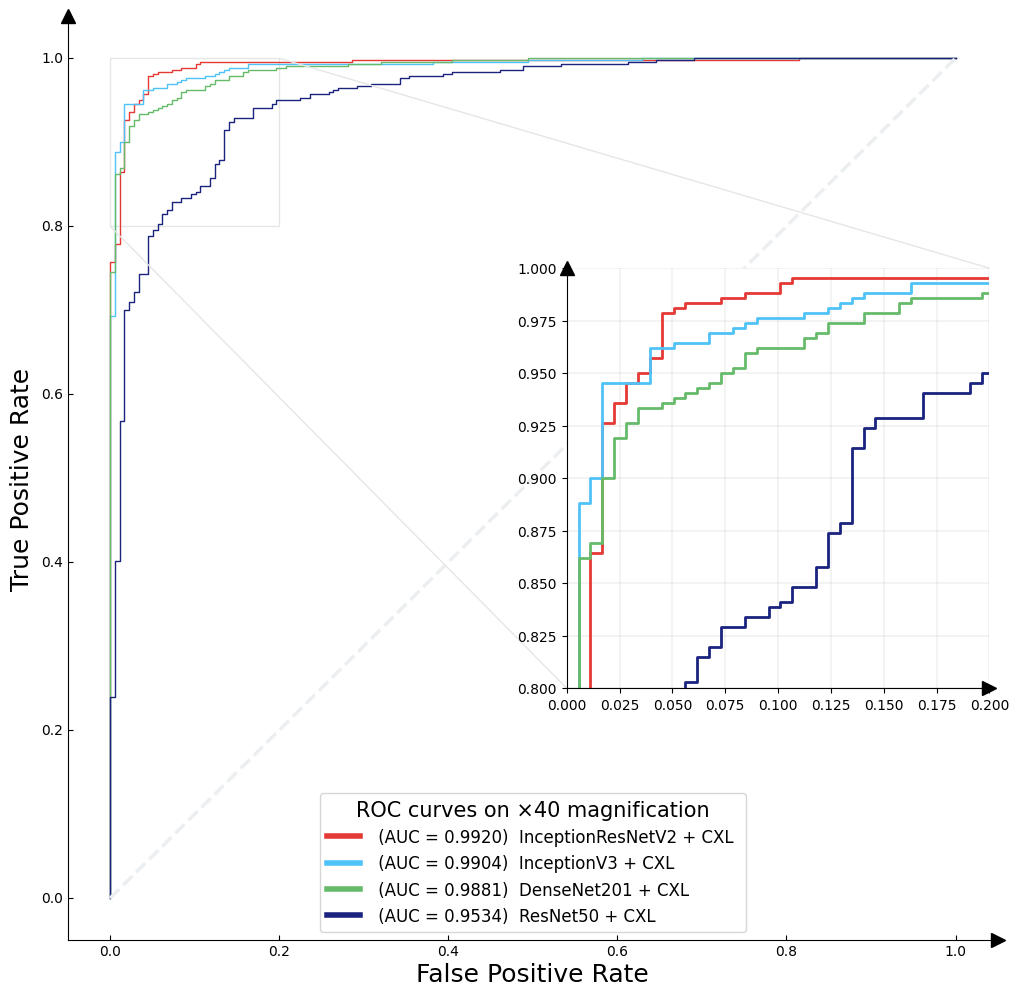

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axisartist.axislines import SubplotZero
matplotlib.rcdefaults()
plt.rcParams.update({'xtick.labelsize':10, 
                     'ytick.labelsize':10,
                     'legend.fontsize':12,
                     'axes.edgecolor' : 'black',
                     'legend.title_fontsize' : 15,
                     'figure.figsize': (12,12),
                     'axes.labelsize' :18})

def mplot(ax, lw = 1):
  f_Inv3, t_Inv3, _ = roc_curve(y_test_Inv3, e_Inv3[6])
  f_IRv2, t_IRv2, _ = roc_curve(y_test_IRv2, e_IRv2[6])
  f_D201, t_D201, _ = roc_curve(y_test_D201, e_D201[6])
  f_RN50, t_RN50, _ = roc_curve(y_test_RN50, e_RN50[6])

  ax.axis['top'].set_visible(False)
  ax.axis['right'].set_visible(False)

  ax.plot(f_IRv2, t_IRv2, color="#E53935", lw=lw, label= f" (AUC = {auc(f_IRv2, t_IRv2):.4f})  InceptionResNetV2 + CXL ")
  ax.plot(f_Inv3, t_Inv3, color="#4FC3F7", lw=lw, label= f" (AUC = {auc(f_Inv3, t_Inv3):.4f})  InceptionV3 + CXL       ")
  ax.plot(f_D201, t_D201, color="#66BB6A", lw=lw, label= f" (AUC = {auc(f_D201, t_D201):.4f})  DenseNet201 + CXL       ")
  ax.plot(f_RN50, t_RN50, color="#1A237E", lw=lw, label= f" (AUC = {auc(f_RN50, t_RN50):.4f})  ResNet50 + CXL          ")
  ax.plot([0, 1], [0, 1], color="#ECEFF1", lw=2.5, linestyle="--")


  
fig = plt.figure(1)
ax = SubplotZero(fig, 111)
fig.add_subplot(ax)

mplot(ax)
ax.plot(-0.05, 1.05, ls="", marker="^", ms=10, color="k", clip_on=False)
ax.plot(1.05, -0.05, ls="", marker=">", ms=10, color="k", clip_on=False)
ax.set_ylim((-0.05), (1.05))
ax.set_xlim((-0.05), (1.05))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
leg = plt.legend(loc="lower center", title = f"ROC curves on ×40 magnification")
for line in leg.get_lines():
    line.set_linewidth(4.0)


axin1 = zoomed_inset_axes(ax, 2.5, loc='right')
mplot(axin1, 2)
axin1.plot(0, 1, ls="", marker="^", ms=10, color="k", clip_on=False)
axin1.plot(0.2, 0.8, ls="", marker=">", ms=10, color="k", clip_on=False)
axin1.set_xlim(0.0, 0.2)
axin1.set_ylim(0.8, 1.0)
axin1.grid(linewidth = 0.2)

mark_inset(ax, axin1, loc1=1, loc2=3, fc="none", ec="0.9")


plt.savefig(working_dir+"/roc_40x.svg", format="svg", bbox_inches='tight')
plt.savefig(working_dir+"/roc_40x.pdf", format="pdf", bbox_inches='tight')
plt.show()

